<a href="https://colab.research.google.com/github/fire-long/24-1AI-ML/blob/main/W12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
cd /content/drive/MyDrive/24-1인공지능과기계학습

/content/drive/MyDrive/24-1인공지능과기계학습


## 8.3 주성분 분석

In [1]:
#데이터셋 생성을 위한 추가 코드
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3)) #3D data init
np.random.seed(42)
angles=(np.random.rand(m) ** 3 + 0.5) * 2 * np.pi#고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5 #타원형
X += 0.28 * np.random.randn(m, 3) #노이즈 추가
X = Rotation.from_rotvec([np.pi/29, -np.pi/20, np.pi/4]).apply(X)
X+=[0.2, 0, 0.2] #약간 이동

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [2]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [4]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser = 'auto') #futre warning을 안 뜨게 하고자 parser option 추가
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[:60_000], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d == 154

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [8]:
pca.explained_variance_ratio_.sum()

0.9501960192613035

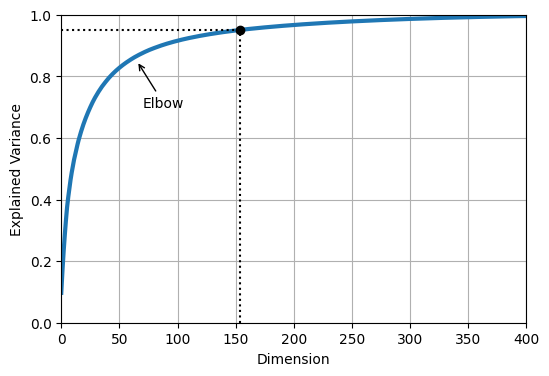

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimension")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy= (65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components":np.arange(10, 80),
    "randomforestclassifier__n_estimators":np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [13]:
X_recovered = pca.inverse_transform(X_reduced)

In [14]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [16]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [18]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train # 대신 반복을 사용해 데이터를 한 청크씩 저장 가능
X_mmap.flush()

In [19]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)